/tmp/ipykernel_139384/2845514955.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_time['IO'] = df_time['read_max'] + df_time['write_max']


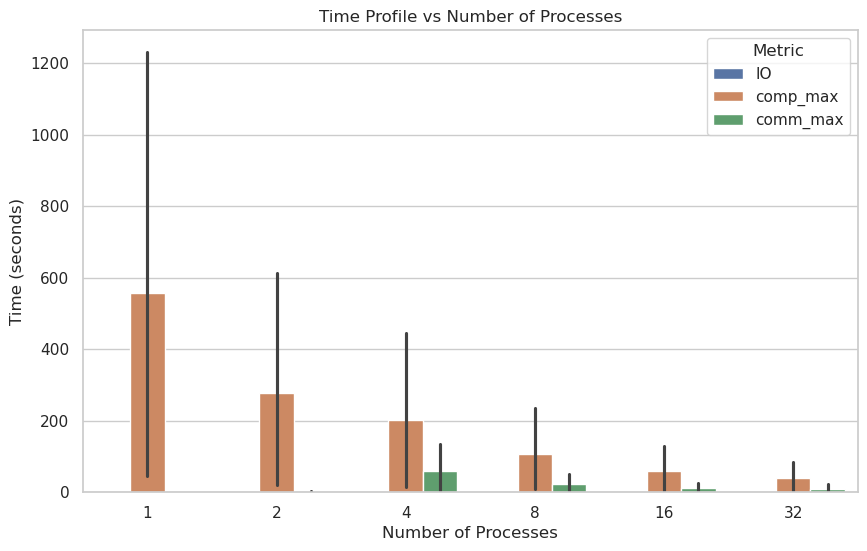

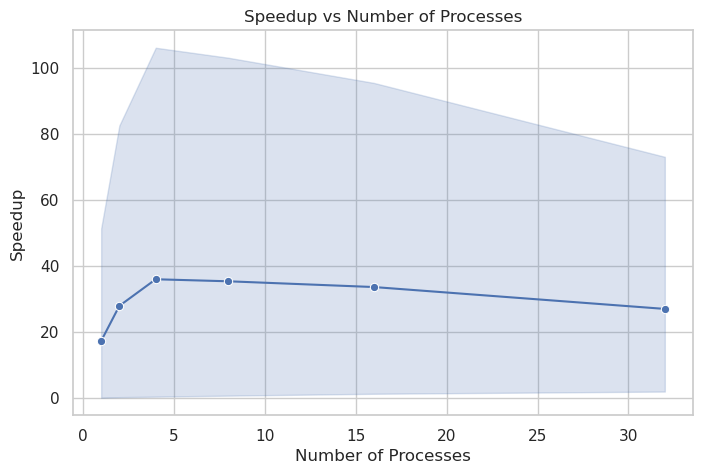

In [ ]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 讀取 CSV
df = pd.read_csv("/home/allenzhuang0117/Parallel-Computing/hw1/metrics.csv")

# 設定美觀
sns.set(style="whitegrid")

# ==== 1. Time Profile：堆疊長條圖 ====
plt.figure(figsize=(10,6))
df_time = df[['size','read_max','sort_max','write_max','comp_max','comm_max']]
df_time['IO'] = df_time['read_max'] + df_time['write_max']
df_time = df_time[['size','IO','comp_max','comm_max']]  # 只留下 IO/計算/通訊
df_time_melted = df_time.melt(id_vars='size', var_name='Metric', value_name='Time(s)')
sns.barplot(x='size', y='Time(s)', hue='Metric', data=df_time_melted)
plt.title("Time Profile vs Number of Processes")
plt.xlabel("Number of Processes")
plt.ylabel("Time (seconds)")
plt.legend(title='Metric')
plt.show()

# ==== 2. Speedup：以單一 process 為 baseline ====
baseline_total = df['total_max'].iloc[0]
df['Speedup'] = baseline_total / df['total_max']

plt.figure(figsize=(8,5))
sns.lineplot(x='size', y='Speedup', marker='o', data=df)
plt.title("Speedup vs Number of Processes")
plt.xlabel("Number of Processes")
plt.ylabel("Speedup")
plt.show()



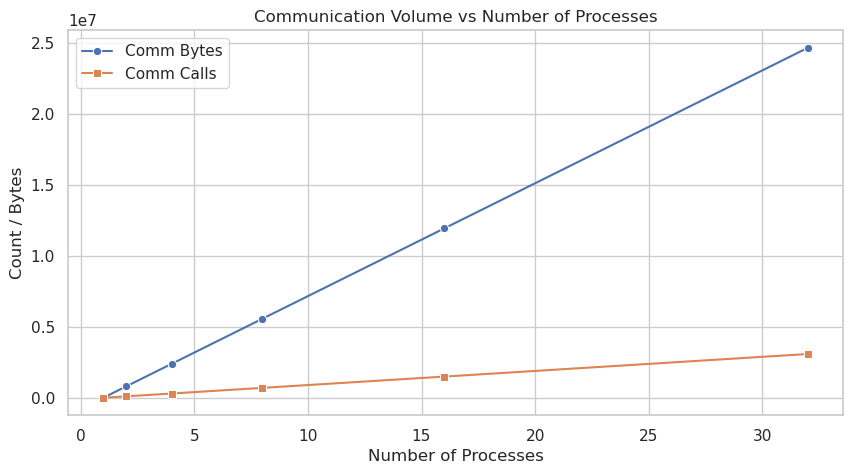

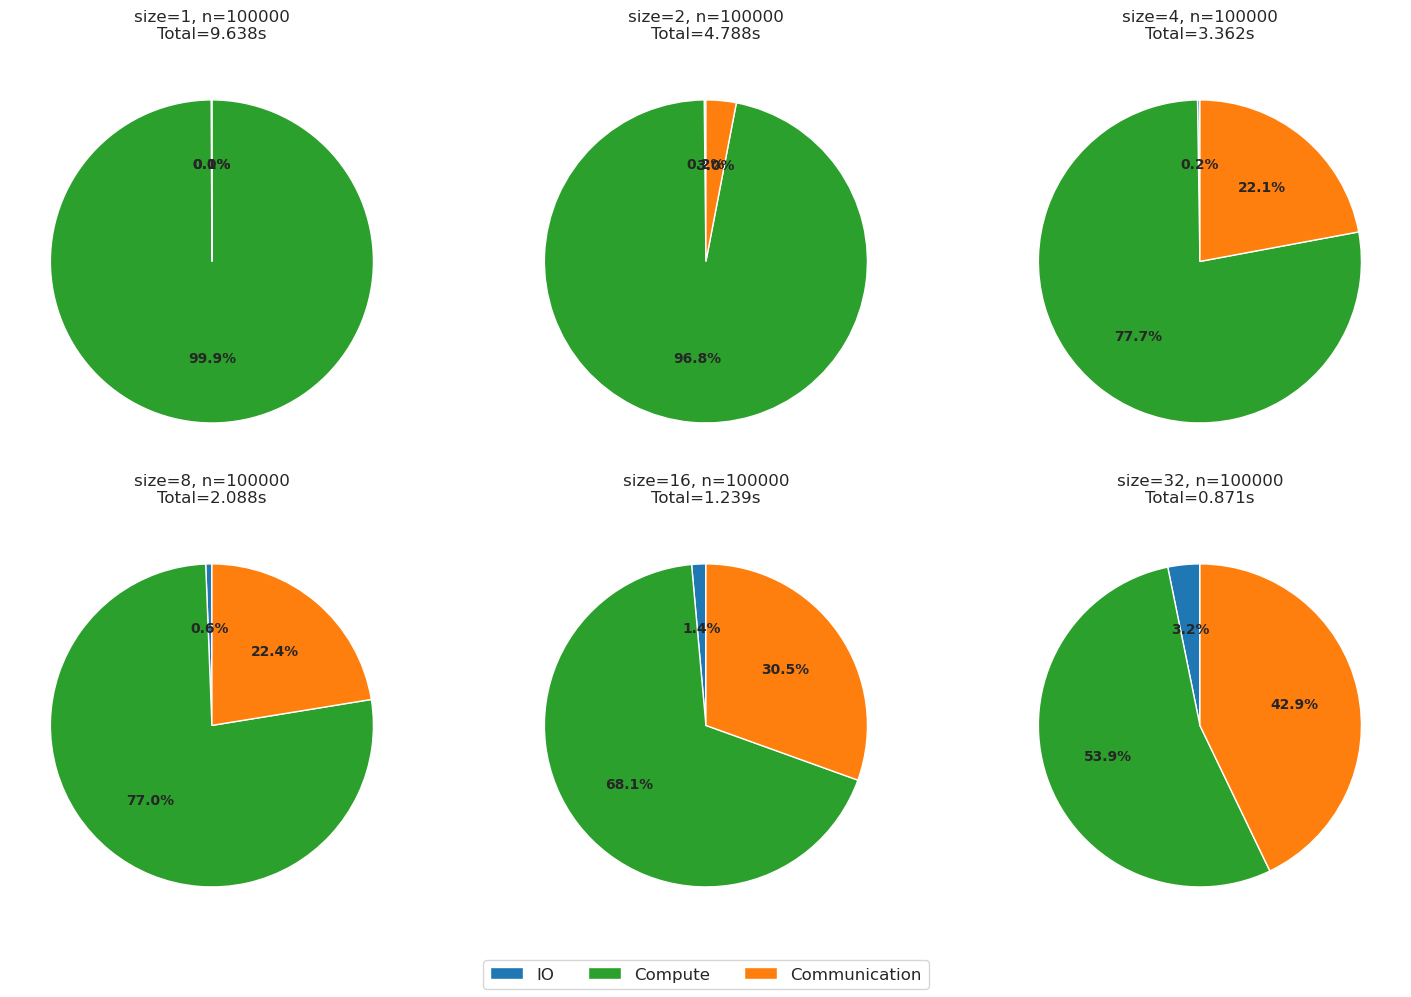

In [12]:

# ==== 3. Communication Bytes & Calls ====
plt.figure(figsize=(10,5))
sns.lineplot(x='size', y='comm_bytes_sum', marker='o', data=df, label="Comm Bytes")
sns.lineplot(x='size', y='comm_calls_sum', marker='s', data=df, label="Comm Calls")
plt.title("Communication Volume vs Number of Processes")
plt.xlabel("Number of Processes")
plt.ylabel("Count / Bytes")
plt.legend()
plt.show()

import pandas as pd
import matplotlib.pyplot as plt

# 讀取 CSV
df = pd.read_csv("metrics.csv")

num_exps = len(df)
cols = 3  # 每列放幾張圖
rows = (num_exps + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*5))

# 統一顏色順序
colors = ['tab:blue', 'tab:green', 'tab:orange']

# 畫圓餅圖
for ax, (_, row) in zip(axes.flat, df.iterrows()):
    io_time = row['read_max'] + row['write_max']
    comp_time = row['comp_max']
    comm_time = row['comm_max']
    total_time = row['total_max']

    wedges, texts, autotexts = ax.pie(
        [io_time, comp_time, comm_time],
        autopct='%1.1f%%',
        startangle=90,
        colors=colors
    )

    # 設定字體大小
    for t in autotexts:
        t.set(size=10, weight="bold")

    # 標題與餅圖保持距離
    ax.set_title(f"size={int(row['size'])}, n={int(row['n'])}\nTotal={total_time:.3f}s", pad=15)

# 把多餘的子圖關掉
for ax in axes.flat[num_exps:]:
    ax.axis("off")

# 加一個共用圖例（在畫布底部或右側）
fig.legend(
    labels=['IO', 'Compute', 'Communication'],
    loc="lower center",
    ncol=3,
    fontsize=12
)

plt.tight_layout(rect=[0,0.05,1,1])  # 預留空間給 legend
plt.show()

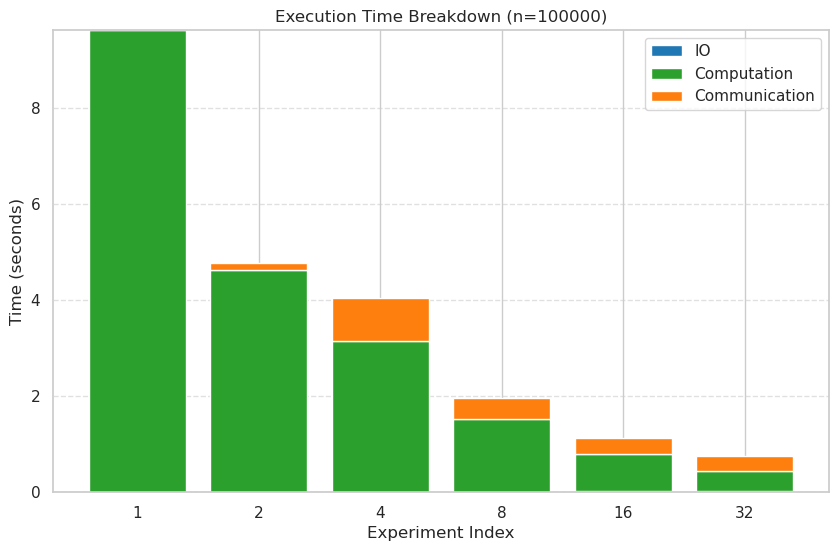

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# 讀取 CSV
df = pd.read_csv("metrics.csv")

# 篩選要畫的欄位
df_plot = df[['size', 'io_max', 'comp_max', 'comm_max']]

# 設定畫布大小
plt.figure(figsize=(10, 6))

# X 軸用 index，保持原始順序
x = range(len(df_plot))

# 堆疊長條圖
plt.bar(x, df_plot['io_max'], label='IO', color='tab:blue')
plt.bar(x, df_plot['comp_max'], bottom=df_plot['io_max'], label='Computation', color='tab:green')
plt.bar(x, df_plot['comm_max'], 
        bottom=df_plot['io_max'] + df_plot['comp_max'], 
        label='Communication', color='tab:orange')

# 標題 & 標籤
plt.title("Execution Time Breakdown (n=100000)")
plt.xlabel("Experiment Index")
plt.ylabel("Time (seconds)")
plt.legend()

# X 軸顯示 size 標籤（原始順序）
plt.xticks(x, df_plot['size'])

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

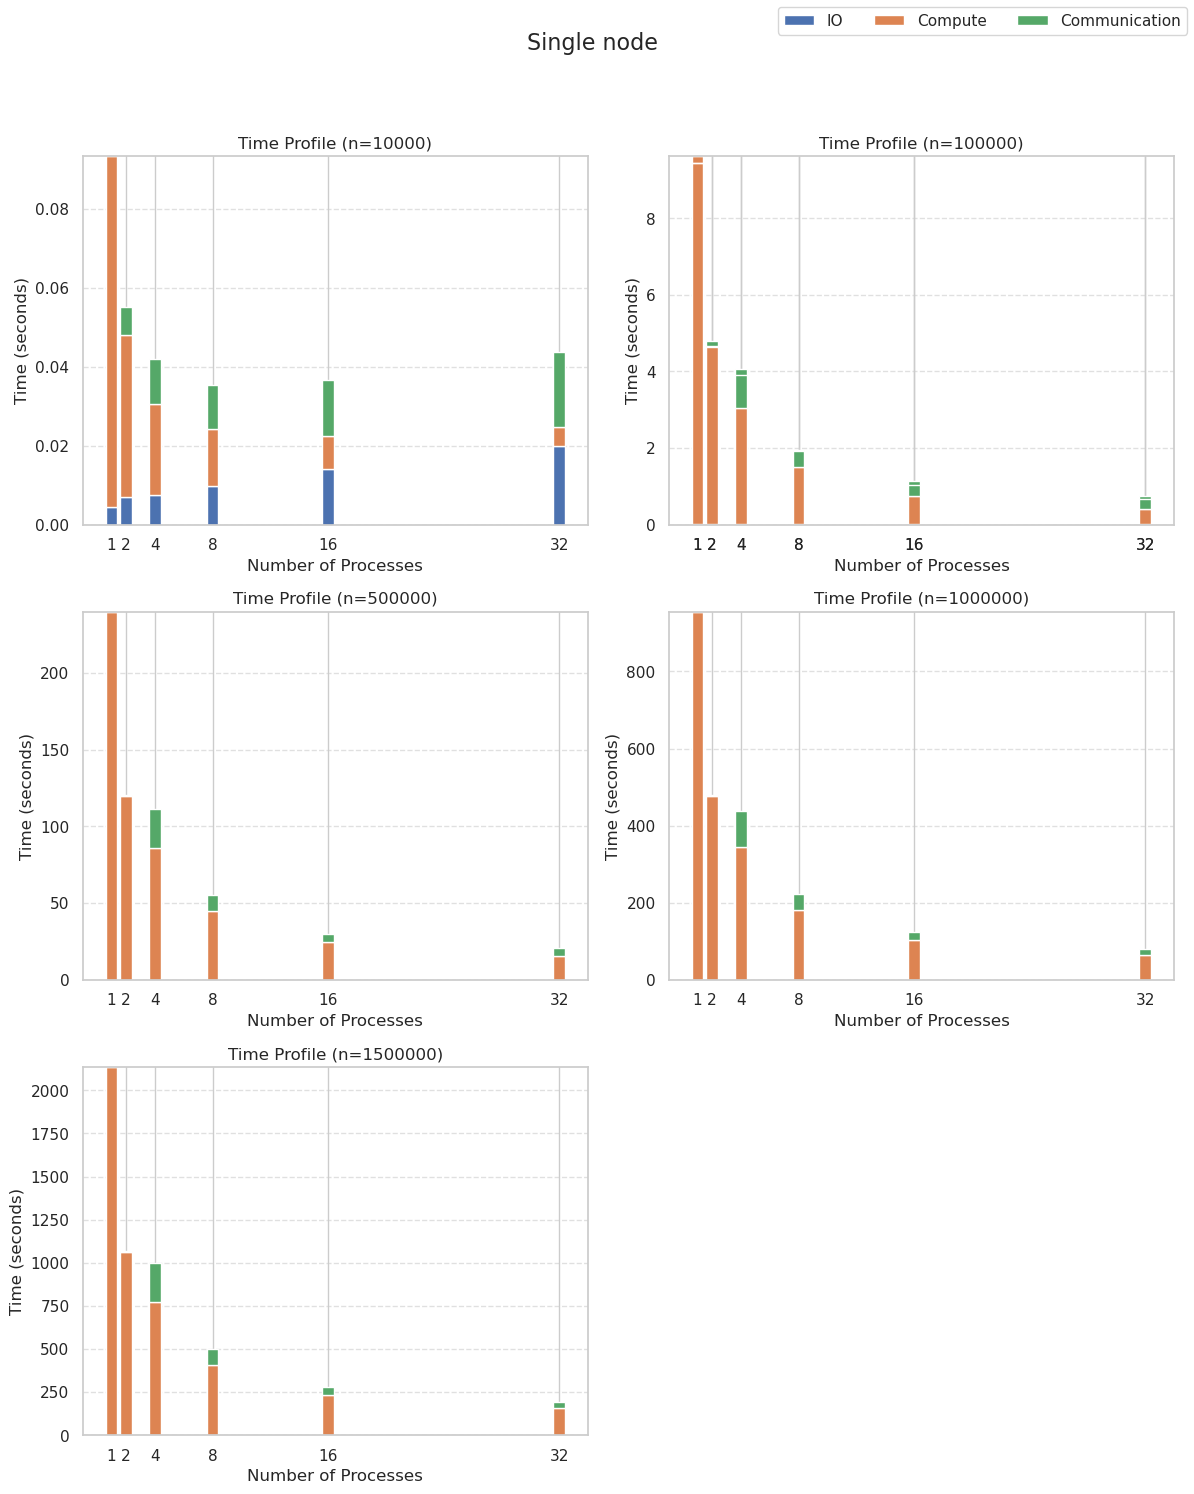

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 讀取 CSV
df = pd.read_csv("/home/allenzhuang0117/Parallel-Computing/hw1/metrics.csv")

# 整理資料
df_time = df[['n','size','read_max','sort_max','write_max','comp_max','comm_max']].copy()
df_time['IO'] = df_time['read_max'] + df_time['write_max']
df_time = df_time[['n','size','IO','comp_max','comm_max']]

# 子圖數量
n_values = sorted(df_time['n'].unique())
cols = 2  # 每列放兩張子圖
rows = (len(n_values) + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(cols*6, rows*5), squeeze=False)

ymax = (df_time[['IO','comp_max','comm_max']].sum(axis=1)).max()


# 繪製每個 n 的子圖
for ax, n_val in zip(axes.flat, n_values):
    subdata = df_time[df_time['n'] == n_val]

    ax.bar(subdata['size'], subdata['IO'], label="IO")
    ax.bar(subdata['size'], subdata['comp_max'],
           bottom=subdata['IO'], label="Compute")
    ax.bar(subdata['size'], subdata['comm_max'],
           bottom=subdata['IO'] + subdata['comp_max'], label="Communication")

    ax.set_title(f"Time Profile (n={n_val})")
    ax.set_xlabel("Number of Processes")
    ax.set_ylabel("Time (seconds)")
    ax.set_xticks(subdata['size'])
    ax.set_ylim(0, ymax * 1.1)
    ax.grid(axis='y', linestyle='--', alpha=0.6)

# 多餘的子圖關掉（如果 n 數量不是剛好 rows*cols）
for ax in axes.flat[len(n_values):]:
    ax.axis("off")

# 圖例放外面，避免每張子圖重複
handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', ncol=3)

fig.suptitle("Single node", fontsize=16)


plt.tight_layout(rect=[0,0,1,0.95])
plt.show()